In [115]:
import numpy as np
import matplotlib.pyplot as plt

## Lloyd's mirror

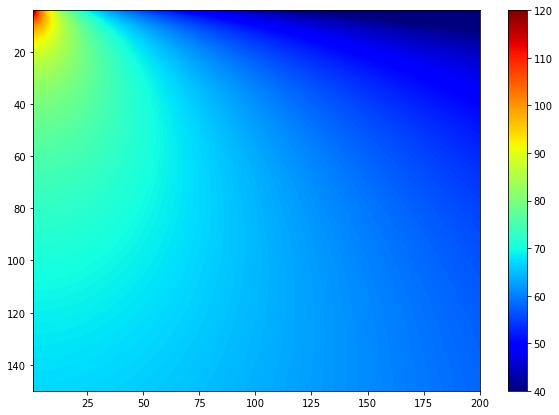

In [116]:
P = 1/1e-06 # 120 dB SPL re 1 \mu Pa
d1, d2 = 4, 45
f = 10
k = 2*np.pi*f
D2 = np.linspace(4, 150, 200)
mapl = np.zeros((200, 200))
for i, d2 in enumerate(D2):
    R = np.linspace(1, 200, 200)
    r1 = np.sqrt(R**2 + (d2 - d1)**2)
    r2 = np.sqrt(R**2 + (d1 + d2)**2)
    spl_direct = 20*(np.log10(P) + 
                     np.log10(np.abs(np.exp(-1j*k*r1/1500)/r1 - 
                                     1*np.exp(-1j*k*r2/1500)/r2)))
    mapl[i, :] = spl_direct
    
fig, ax = plt.subplots(figsize=(10, 7))
c = ax.imshow(mapl, extent=[R[0], R[-1], D2[-1], D2[0]], 
          cmap='jet', vmin=40, vmax=120,
          aspect='auto')
plt.colorbar(c)

In [117]:
class CoordMesh:
    def __init__(self, x, z):
        x = x[:, None]
        x = np.repeat(x, 500, axis=1)

        z = z[None, :]
        z = np.repeat(z, 500, axis=0)
        self.coords = np.stack([x, z], axis=2)
        
    @property
    def x(self):
        return self.coords[:, :, 0]
    
    @property
    def z(self):
        return self.coords[:, :, 1]

## Path and LLoyd functions + mesh test

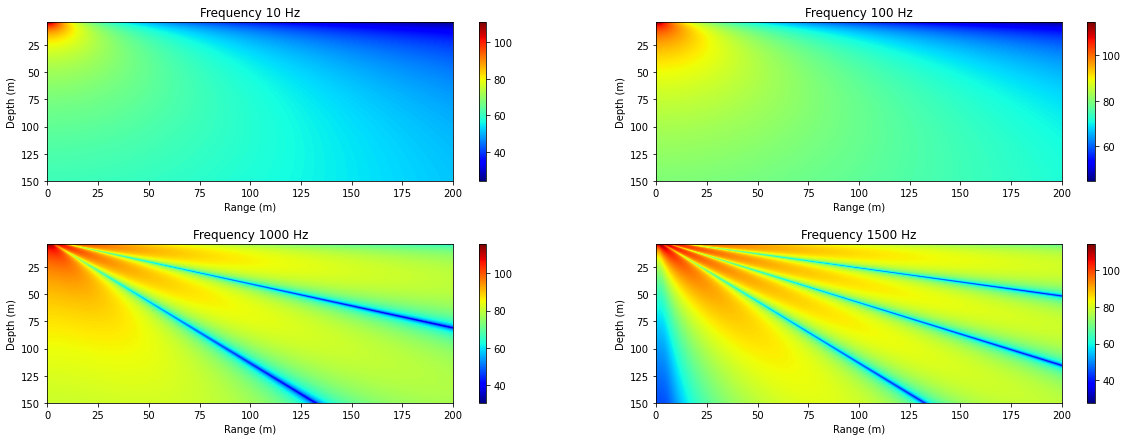

In [118]:
from typing import Union, List, Tuple


def make_path(source, listener, lloyd=False):
    R = source.x - listener.x
    
    if not lloyd: 
        rel_depth = listener.z - source.z
    else:
        rel_depth = listener.z + source.z
        
    return np.sqrt(R**2 + (rel_depth)**2)

def calc_propagation(source_coords:   List[Tuple[float, float]], 
                     listener_coords: List[Tuple[float, float]],
                     f: Union[np.ndarray, list, float, int], 
                     c: [float],
                     path:str='direct'):
    if isinstance(f, list):
        f = np.array(f, dtype=np.float64)
    if path == 'direct':
        lloyd=False
    elif path == 'lloyd':
        lloyd = True
    else:
        raise ValueError
    
    r = make_path(source_coords, listener_coords, lloyd=lloyd)
    if isinstance(f, np.ndarray):
        f = np.broadcast_to(f, r.shape + f.shape)
        r = np.repeat(r[..., None], f.shape[-1], axis=f.ndim - 1)
        
    k = 2*np.pi*f/c
    return np.exp(-1j*k*r)/r

list_pos = 200
x = np.linspace(0, list_pos, 500)
z = np.repeat(2, 500)
source_coords = CoordMesh(x, z)

z = np.linspace(4, 150, 500)
x = np.repeat(list_pos, 500)
listener_coords = CoordMesh(x, z)


f_values = [10, 100, 1000, 1500]
direct_prop = calc_propagation(source_coords, listener_coords, f_values, 1500, path="direct")
lloyd_prop = calc_propagation(source_coords, listener_coords, f_values, 1500, path="lloyd")
P = 1/1e-06
mapl = 20*(np.log10(P) + np.log10(np.abs(direct_prop - lloyd_prop)))
x_ex = source_coords.x[:, 0] # - listener_coords.x
z_ex = listener_coords.z[0, :]
ncols=2
nrows=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 7))
plt.subplots_adjust(hspace=0.4)
fc = 0
for i in range(ncols):
    for j in range(nrows):
        
        rmap = mapl[:, :, i*ncols + j].transpose()[::, ::-1]
        c = axes[i, j].imshow(rmap, extent=[x_ex[0], x_ex[-1], z_ex[-1], z_ex[0]], 
                  cmap='jet',
                  aspect='auto')
        plt.colorbar(c, ax=axes[i,j])
        axes[i, j].set_title(f"Frequency {f_values[fc]} Hz")
        axes[i, j].set_xlabel(f"Range (m)")
        axes[i, j].set_ylabel(f"Depth (m)")
        fc+= 1

## Path test

In [119]:
class CoordPath:
    def __init__(self, x, z):
        x = x[:, None]
        z = z[:, None]
        self.coords = np.stack([x, z], axis=1)
        
    @property
    def x(self):
        return self.coords[:, 0]
    
    @property
    def z(self):
        return self.coords[:, 1]

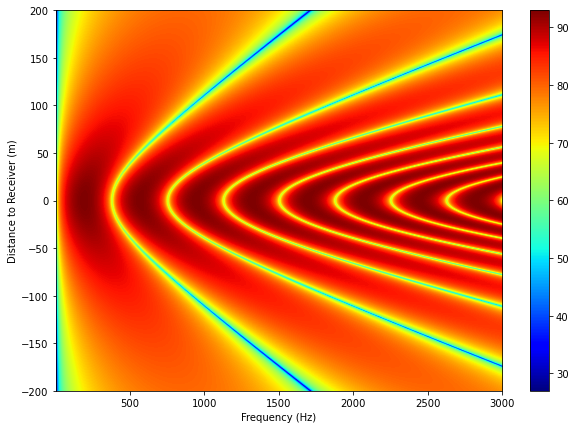

In [120]:
frequencies = np.linspace(1, 3000, 512)

listener_pos = 200
x = np.linspace(0, listener_pos + 200, 1000)
z = np.repeat(2, 1000)
source_coords = CoordPath(x, z)

listener_depth = 45
z = np.repeat(listener_depth, 1000)
x = np.repeat(listener_pos, 1000)
listener_coords = CoordPath(x, z)

direct_prop = calc_propagation(source_coords, listener_coords, frequencies, 1500, path="direct")
lloyd_prop = calc_propagation(source_coords, listener_coords, frequencies, 1500, path="lloyd")
P = 1/1e-06
mapl = 20*(np.log10(P) + np.log10(np.abs(direct_prop - lloyd_prop)))
mapl = mapl.squeeze()
mapl.shape
dis = listener_coords.x - source_coords.x
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
c = ax.imshow(mapl, extent=[frequencies[0], frequencies[-1], dis[-1], dis[0]], 
                      cmap='jet',
                      aspect='auto')
ax.set_ylabel("Distance to Receiver (m)")
ax.set_xlabel("Frequency (Hz)")
plt.colorbar(c, ax=ax)

In [121]:
from scipy.fft import rfft, irfft, rfftfreq
from scipy.signal import windows
import librosa.util as util
import librosa
from librosa import stft
import librosa.display

def colored_noise(nsamples, sr, alpha=1):
    wnoise = np.random.uniform(-0.5, 0.5, size=nsamples)
    sxx_w = rfft(wnoise)
    freqs = rfftfreq(nsamples, d=1/sr)
    
    sxx_p = sxx_w.copy()
    sxx_p[1:] = sxx_w[1:]/np.sqrt(freqs[1:]**alpha)
    
    pnoise = irfft(sxx_p)
    return pnoise
    

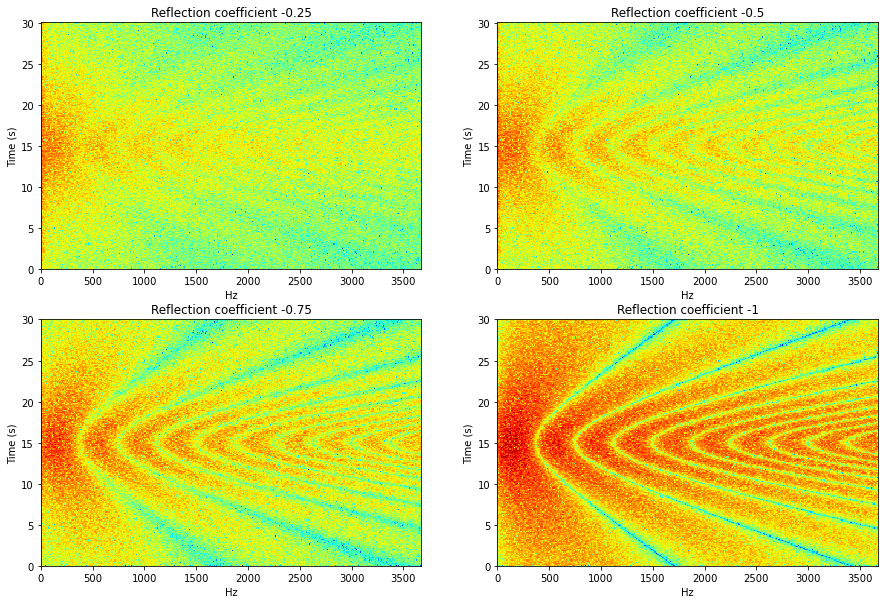

In [122]:
seconds=30
sr=7350
nfft=1024
# att=10*
noise = colored_noise(seconds*sr, sr, alpha=1)

sxx =stft(noise, n_fft=nfft, hop_length=nfft)
sxx = np.abs(sxx).transpose()
scene_length = sxx.shape[0]

frequencies = librosa.fft_frequencies(sr=sr, n_fft=nfft)

listener_pos = 200
x = np.linspace(0, listener_pos + 200, scene_length)
z = np.repeat(2, scene_length)
source_coords = CoordPath(x, z)

listener_depth = 45
z = np.repeat(listener_depth, scene_length)
x = np.repeat(listener_pos, scene_length)
listener_coords = CoordPath(x, z)

direct_prop = calc_propagation(source_coords, listener_coords, frequencies, 1500, path="direct")
lloyd_prop = calc_propagation(source_coords, listener_coords, frequencies, 1500, path="lloyd")
S = 1/1e-06
sxx = util.normalize(sxx, norm=np.inf, axis=None)
sxx = 20*np.log10(sxx)

# sxx[sxx < 0] = 0
mu_list = [-0.25, -0.50, -0.75, -1]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
plt.subplots_adjust(wspace=0.2)
for i in range(2):
    for j in range(2):
        mapl = 20*(np.log10(P) + np.log10(np.abs(direct_prop + mu_list[i*2 + j]*lloyd_prop)))
        mapl = mapl.squeeze()
        mapl = mapl[::-1, ::]
        
        sxx_scene = sxx + mapl
        cmap  = librosa.display.specshow(sxx_scene ,sr=sr, hop_length=nfft, x_axis='linear', y_axis='s', cmap='jet', ax=axes[i,j])
        plt.colorbar(cmap, ax, axes[i,j])
        axes[i,j].set_title(f"Reflection coefficient {mu_list[i*2 + j]}")
# sxx = 20*np.log10(sxx)

In [123]:
class Scenery():
    def __init__(self, time, propagation_model='spherical'):
        self.propagation_model = propagation_model
        self.lloyd_mirror = False
        self.sources = list()
        self.receivers = list()
        self.t = time
        
    def set_lloyd_mirror(self, state):
        self.lloyd_mirror = state
        
    def add_source(self, name, coords, audio_collection):
        raise NotImplementedError
    
    def add_receiver(self, name, coords): 
        raise NotImplementedError
